# AAI3001 Final Project - Preliminary Research Notebook

### Group 8

- Chua Chen Yi

- Wong Jun Kai

- Leena Soo Wei Qi

- Heng Yu Xin



#### In this notebook, we conduct a brief sanity check of our progress, primarily to confirm that:

1. Our dataset has been properly formatted.

2. We are able to apply transfer learning to a pre-trained YOLO model.

3. The initial model performance is satisfactory.



## Dataset Details



#### Initial Dataset (350 Images)

Our initial dataset consists of 350 Images. These are recorded from the 3D printer's built in webcam. We obtain our images as snapshots from a mix of timelapse and regular videos. These have been roughly split into 65:25:10 (train/val/test), of these, 157 have at least one failure in them, and the remaining are background images.



- #### Timelapse Videos

These captures movement across the entire print cycle, and are representative of an entire print, which takes more than an hour on averages. Frames are captured at the start of each layer, where each layer is 0.2mm in height. Therefore an object of 1cm will have 5 frames captures. However, a shortfall of this method is key moments, such as the start of a print failure occuring might get missed if they do not occur at the start of the new layer.

- #### Regular Videos

These captures movement across a specific moment in the print cycle. We record the entire footage and pick out key moments. We use this to capture the initial moments where the print failure occurs. As this is a regular 30FPS video, we are able to capture more frames and populate our dataset with these key moments. As 30FPS will generate too many similar images, we record them in a 15:1 ratio (We capture one frame for every 15 frame of video). This is till much faster than timelapse, which might only capture a single image every 2+ mins.



Unfortunately, we were unable to organically capture an actual failure. Hence we have to simulate one. In particular, we will focus on ["spaghetti"](https://help.prusa3d.com/article/spaghetti-monster_1999) failures, which are the most common form of failure that has no recovery. I.e. encountering one will result in the print having to be completely discarded and restarted.



The failures from this initial dataset is simulated by printing a very thin but tall object. When it inevitably falls over, filament will get dragged everywhere.



#### Updated Dataset (630 Images)

Based on the initial testing, we have updated the dataset with 280 more images. These are obtained similarly to the initial dataset, but using seperate camera for another slightly different perspective. These additional images are split into (80:10:10) where 145 of 280 images have at least one failure in them. The failures simulated are also done using two different methods:



We designed [two files](https://cad.onshape.com/documents/f5fa610d41301785390c590c/w/85f44a550e1a6889dc6a74d6/e/ebb2803dda6e79d8e5a7e7c0?renderMode=0&uiState=6743750fd0d06252d2c72f97) that when printed will result in failure:



- File-1: Unsupported cantiliver. This simulates a spagehetti failure mid-print. This can occur of the print belts skip, or due to a bad design which causes the printer to print "mid-air".



- File-2: Lack of adhesion. This simulates when the print surface is dirty, and the first layer does not stick to it, similar to the initial dataset. The filament will be dragged around a large area.







## Dataset Annotation

We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [1]:
# Dataset root folder

dataset_path = r"/kaggle/input/3dprint/3dprint"

# Images
train_folder = dataset_path + r"/images/train"
test_folder = dataset_path + r"/images/test"
val_folder = dataset_path + r"/images/val"

# Labels
train_label_folder = dataset_path + r"/labels/train"
test_label_folder = dataset_path + r"/labels/test"
val_label_folder = dataset_path + r"/labels/val"

In [2]:
# Import Stuff

import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [3]:
# Helper function to preview bounding box. 

def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:

        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

/kaggle/input/3dprint/3dprint/labels/train/FB11.txt
/kaggle/input/3dprint/3dprint/labels/train/BG46.txt
/kaggle/input/3dprint/3dprint/labels/train/BG97.txt


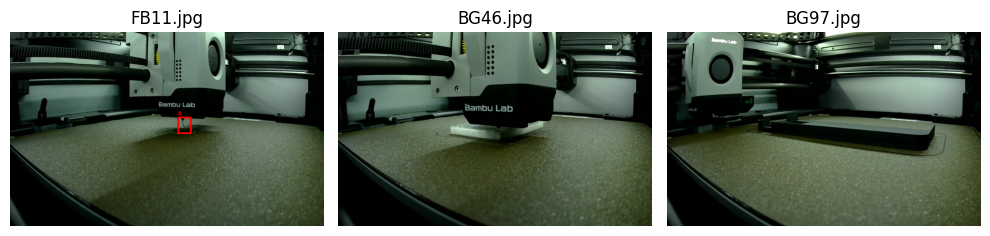

In [4]:
# Get a list of all image files in the folder

image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder

if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

In [5]:
import cv2
import numpy as np
import random

# Occlusion augmentation: Simulate blocked views
def apply_occlusion(image):
    h, w, _ = image.shape
    x1, y1 = random.randint(0, w // 2), random.randint(0, h // 2)
    x2, y2 = random.randint(w // 2, w), random.randint(h // 2, h)
    image[y1:y2, x1:x2] = 0  # Apply a black patch
    return image

# Synthetic failure augmentation: Add random "failure patterns"
def apply_synthetic_failure(image):
    h, w, _ = image.shape
    for _ in range(random.randint(1, 3)):  # Add 1 to 3 synthetic blobs
        cx, cy = random.randint(0, w), random.randint(0, h)
        radius = random.randint(10, 50)  # Blob size
        color = (255, 255, 255)  # White blobs
        cv2.circle(image, (cx, cy), radius, color, -1)  # Draw filled circle
    return image

# Edge detection augmentation: Highlight structural details
def apply_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)  # Apply Canny
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert back to BGR
    return edges_colored


In [6]:
import cv2
import numpy as np
import random

# Occlusion augmentation: Simulate blocked views
def apply_occlusion(image):
    h, w, _ = image.shape
    x1, y1 = random.randint(0, w // 2), random.randint(0, h // 2)
    x2, y2 = random.randint(w // 2, w), random.randint(h // 2, h)
    image[y1:y2, x1:x2] = 0  # Apply a black patch
    return image

# Synthetic failure augmentation: Add random "failure patterns"
def apply_synthetic_failure(image):
    h, w, _ = image.shape
    for _ in range(random.randint(1, 3)):  # Add 1 to 3 synthetic blobs
        cx, cy = random.randint(0, w), random.randint(0, h)
        radius = random.randint(10, 50)  # Blob size
        color = (255, 255, 255)  # White blobs
        cv2.circle(image, (cx, cy), radius, color, -1)  # Draw filled circle
    return image

# Edge detection augmentation: Highlight structural details
def apply_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)  # Apply Canny
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert back to BGR
    return edges_colored


In [7]:
import os
import cv2
import random
from tqdm import tqdm

def augment_and_save_images(input_folder, output_folder, augmentations):
    """Applies augmentations to images and saves them to a new folder."""
    os.makedirs(output_folder, exist_ok=True)
    
    for image_file in tqdm(os.listdir(input_folder)):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, image_file)
            image = cv2.imread(image_path)

            # Apply augmentations sequentially
            for augmentation in augmentations:
                if random.random() < 0.5:  # Apply with 50% probability
                    image = augmentation(image)
            
            # Save the augmented image
            output_path = os.path.join(output_folder, image_file)
            cv2.imwrite(output_path, image)

# Define input and output paths
train_augmented_folder = "/kaggle/working/augmented_train"
augment_and_save_images(train_folder, train_augmented_folder, [
    apply_occlusion,
    apply_synthetic_failure,
    apply_edge_detection
])


100%|██████████| 225/225 [00:06<00:00, 35.22it/s]


# Sanity Check - Train Model

#### Use transfer learning on a pre-trained YOLOv11 model, then evaluate

In [8]:
# Import stuff
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 19.4 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
# Create a new YOLO model from scratch
model = YOLO("yolo11n.yaml")

# Load a pretrained YOLO model
model = YOLO("yolo11n.pt")
results = model.train(data="/kaggle/input/augmented-3dprint-yaml/3dprint.yaml", epochs=60,
        lr0=0.001,
        batch=16,             
        patience = 20,
      )

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.3MB/s]


Ultralytics 8.3.38 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/augmented-3dprint-yaml/3dprint.yaml, epochs=60, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]
2024-11-26 15:22:38,601	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-26 15:22:39,374	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 462.47it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/3dprint/3dprint/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 277.12it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.62G      2.574      6.951      1.836         22        640: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         85         41    0.00102      0.634    0.00149   0.000394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.64G      2.469      5.271      1.691         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

                   all         85         41    0.00118      0.732    0.00291      0.001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.63G      2.401      4.391      1.738         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]

                   all         85         41    0.00129      0.805    0.00248   0.000869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.63G      2.353       4.29      1.668         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]

                   all         85         41    0.00141      0.878    0.00467    0.00181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.63G      2.312      4.342      1.743         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

                   all         85         41    0.00137      0.854     0.0183    0.00567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.63G      2.354      3.551      1.782          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]

                   all         85         41       0.27     0.0976      0.174     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.63G      2.197      3.389      1.684         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         85         41      0.747      0.171      0.375      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.63G      2.506      4.506      1.765         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

                   all         85         41      0.578      0.415      0.495      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.63G      2.265       3.36      1.686         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]

                   all         85         41      0.412      0.546      0.444      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.63G      2.316      2.902      1.718         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         85         41      0.512      0.415      0.409      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.63G      2.227      2.667      1.649          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]

                   all         85         41      0.526      0.585      0.555      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.63G        2.3      2.646      1.691         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]

                   all         85         41      0.485      0.756      0.643      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.63G      2.144      2.295       1.71         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]

                   all         85         41      0.749      0.463      0.622      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.64G      2.134      2.166      1.722          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]

                   all         85         41      0.651      0.488      0.587      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.63G      2.212      2.153      1.692         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]

                   all         85         41      0.518      0.561      0.548      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.63G      2.138       2.16      1.638         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

                   all         85         41      0.666      0.585      0.599      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.63G      2.083       2.06      1.695         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]

                   all         85         41      0.497      0.585      0.485      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.63G      2.165      2.043      1.689         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.58it/s]

                   all         85         41      0.581      0.542       0.57       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.63G      2.094      1.849      1.616         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


                   all         85         41       0.59      0.659      0.651      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.63G      2.109      1.848      1.664          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


                   all         85         41      0.589       0.63       0.59      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.63G      2.062      1.697      1.603         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.91it/s]

                   all         85         41      0.708      0.532      0.608      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      2.63G      2.079      1.711       1.58         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]

                   all         85         41       0.66      0.663      0.636      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.63G      2.052      1.702      1.588         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

                   all         85         41      0.651      0.727        0.7      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.63G      2.038      1.678      1.613          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]

                   all         85         41      0.611      0.768      0.652      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.63G      1.959      1.605      1.557         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.67it/s]

                   all         85         41      0.766      0.638      0.684      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.62G      1.994      1.593      1.575         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]

                   all         85         41      0.659        0.8      0.718      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      2.63G      1.939      1.481      1.539          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


                   all         85         41       0.75      0.805      0.803      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      2.62G      1.936      1.397      1.525         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         85         41      0.757      0.762        0.8       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.63G      2.033      1.503      1.612          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         85         41        0.7      0.732      0.722      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      2.62G      1.978      1.442      1.614          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]

                   all         85         41      0.707      0.708      0.766        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      2.63G      1.844      1.335      1.533         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         85         41      0.712       0.78      0.782      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.64G      1.842      1.343      1.543         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]

                   all         85         41      0.828      0.805      0.832      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.63G      1.984      1.387      1.562         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]

                   all         85         41      0.835      0.739      0.797      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.62G      1.823      1.271      1.446         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

                   all         85         41      0.768      0.726      0.758      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.63G      1.964       1.28      1.508         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]

                   all         85         41       0.68      0.756      0.798      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.62G      1.823      1.313      1.484         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]

                   all         85         41      0.768      0.729      0.797      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.63G      1.769       1.22      1.472         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]

                   all         85         41      0.701      0.756      0.775      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.62G      1.777      1.205      1.441         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]

                   all         85         41      0.672      0.829      0.741      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.63G      1.798      1.159      1.434         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

                   all         85         41      0.625      0.756      0.707      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.62G       1.81      1.232      1.424         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]


                   all         85         41        0.9      0.656      0.761      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.63G       1.85       1.27       1.45         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

                   all         85         41       0.75      0.756      0.785      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.62G      1.818      1.154       1.47         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]

                   all         85         41      0.795      0.756      0.793      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.63G      1.891      1.201       1.45         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.87it/s]

                   all         85         41      0.873      0.756        0.8      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.62G      1.763      1.201      1.491         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         85         41      0.737       0.82      0.824      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.63G      1.853      1.184      1.483         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]

                   all         85         41      0.799       0.78      0.817      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.64G      1.693      1.139      1.445         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


                   all         85         41      0.829       0.78      0.837      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.63G      1.757      1.204      1.484         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         85         41       0.83      0.836      0.861      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.62G      1.766      1.145      1.518         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

                   all         85         41      0.887      0.766      0.871       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.63G      1.817      1.142      1.465         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

                   all         85         41      0.762      0.861      0.869      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.63G      1.631      1.122       1.41          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]

                   all         85         41      0.787      0.829      0.837      0.324


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.63G      1.661      1.237      1.522         14        640: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]

                   all         85         41      0.811      0.805      0.841      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.63G      1.719      1.172       1.47          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.03it/s]

                   all         85         41      0.845      0.797      0.862      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.63G      1.654      1.115       1.53         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         85         41      0.831      0.839      0.867      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.62G       1.55      1.137      1.422          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

                   all         85         41       0.77      0.878      0.839      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.63G      1.629      1.135      1.456          3        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all         85         41      0.823       0.78      0.858      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.63G      1.564      1.123      1.409          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         85         41      0.843      0.829      0.858      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.63G      1.664       1.24       1.45         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

                   all         85         41      0.871      0.823      0.838       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.63G      1.546      1.103      1.409          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         85         41      0.871      0.825      0.864       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.63G      1.514       1.04      1.425          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

                   all         85         41       0.84      0.829      0.862      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.62G      1.466      1.062       1.39          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.99it/s]

                   all         85         41      0.848      0.813      0.856      0.344



60 epochs completed in 0.070 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


                   all         85         41      0.849      0.821      0.857      0.345
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


In [10]:
# Evaluate the model's performance on the validation set
results = model.val()

Ultralytics 8.3.38 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1292.53it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


                   all         85         41      0.847      0.829      0.854      0.338
Speed: 0.3ms preprocess, 9.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2


# View Results

In [13]:
# Load the generated images
image1 = r"/kaggle/working/runs/detect/train2/val_batch0_labels.jpg"
image2 = r"/kaggle/working/runs/detect/train2/val_batch0_pred.jpg"
image3 = r"/kaggle/working/runs/detect/train2/val_batch1_labels.jpg"
image4 = r"/kaggle/working/runs/detect/train2/val_batch1_pred.jpg"

------------------ [PREDICTION] /kaggle/working/runs/detect/train2/val_batch0_labels.jpg ------------------


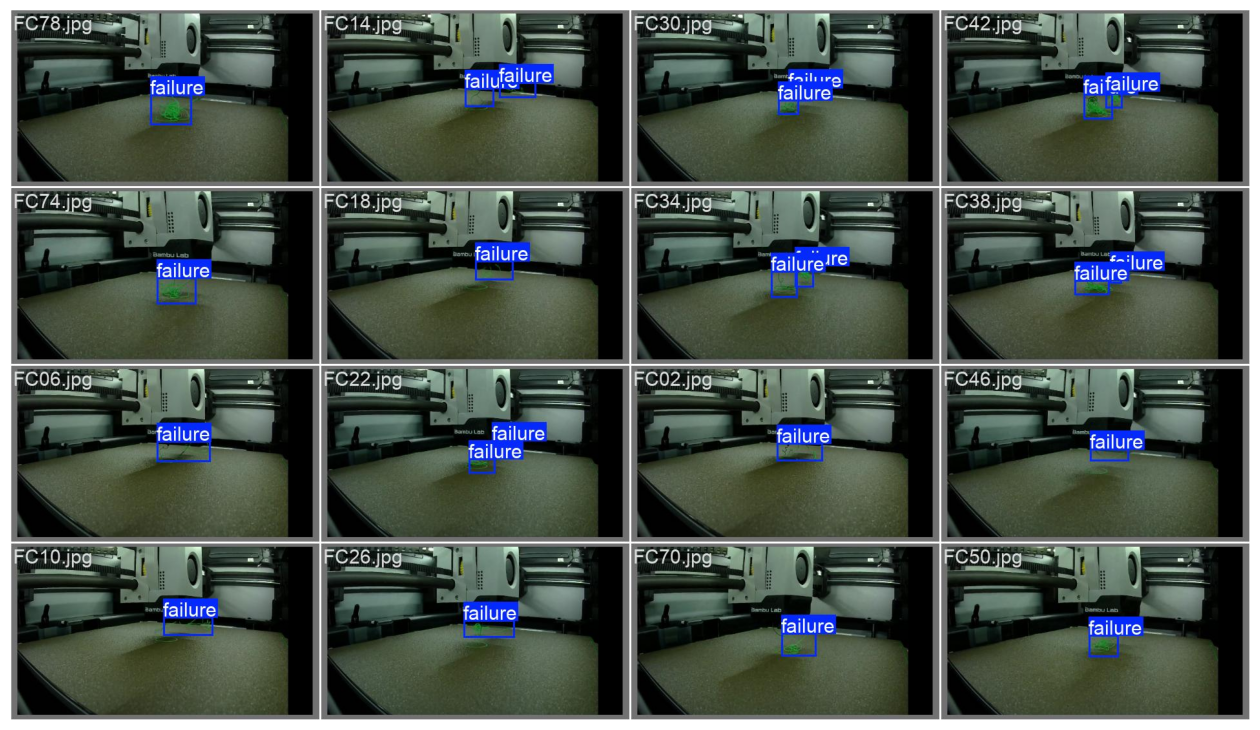



------------------ [LABEL] /kaggle/working/runs/detect/train2/val_batch0_pred.jpg ------------------


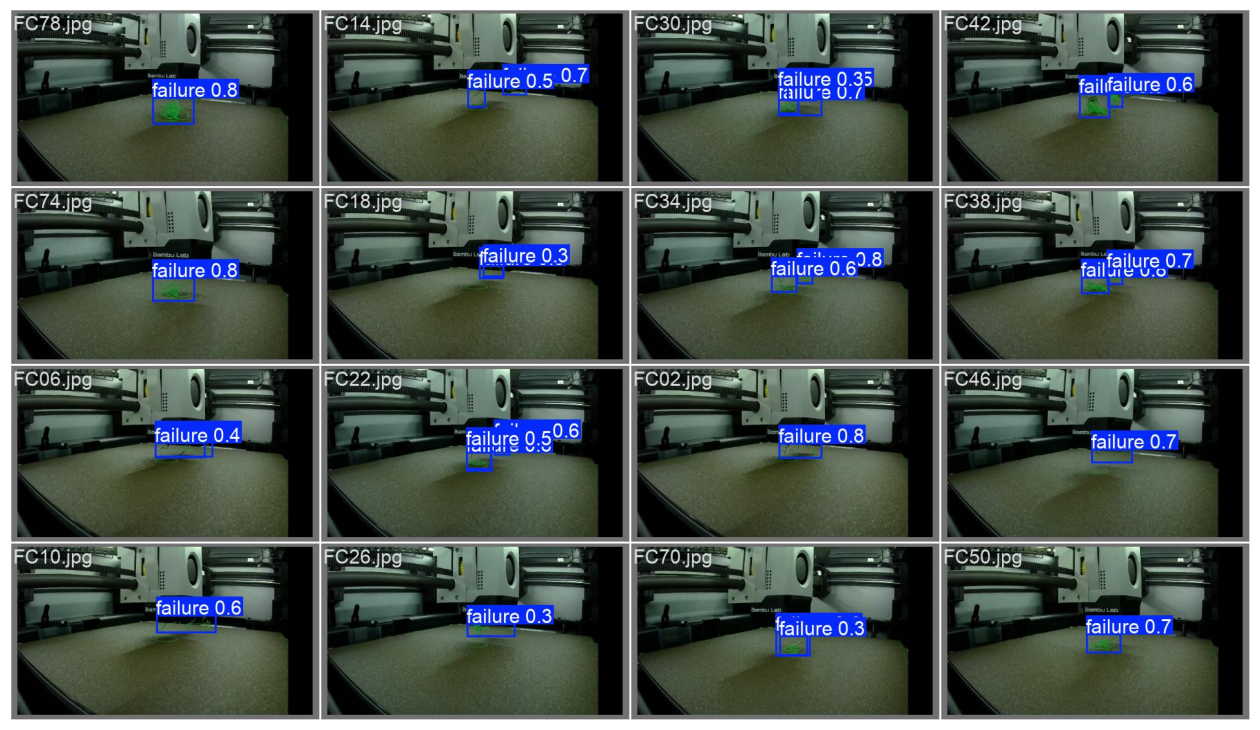



------------------ [PREDICTION] /kaggle/working/runs/detect/train2/val_batch1_labels.jpg ------------------


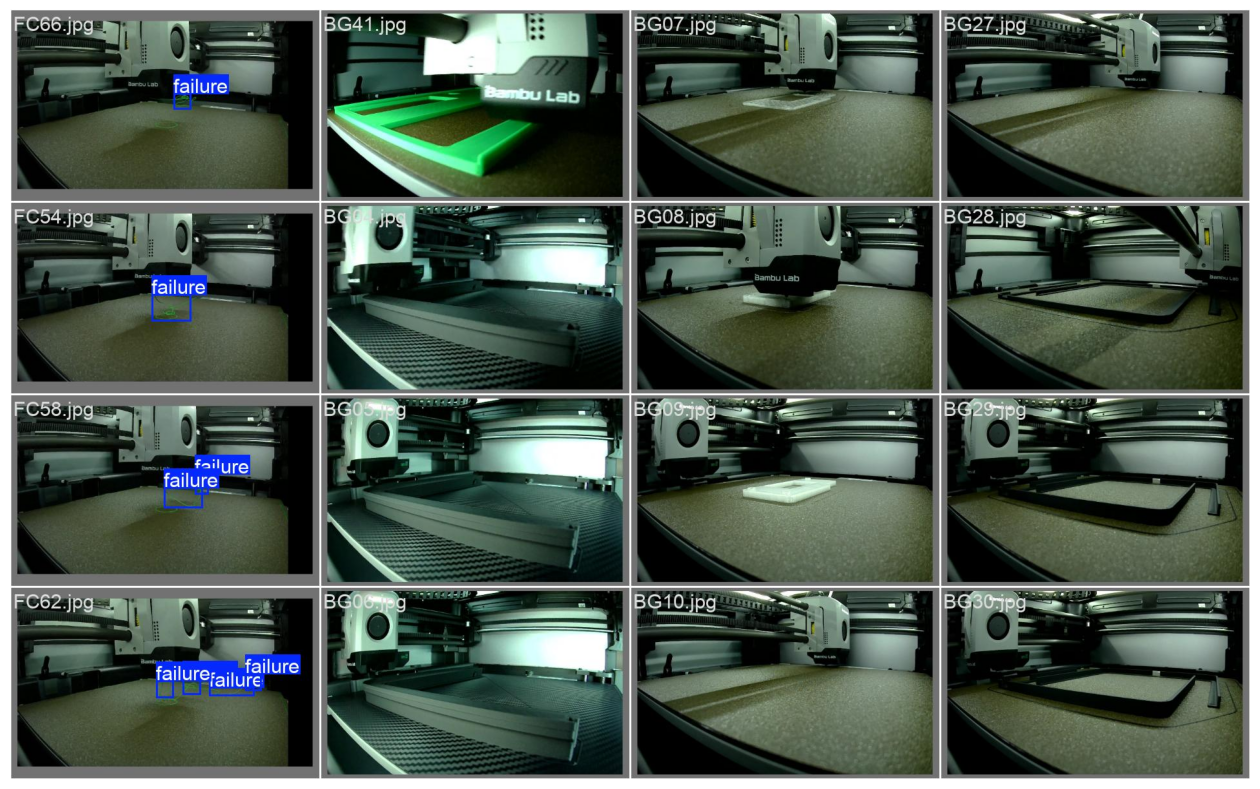



------------------ [LABEL] /kaggle/working/runs/detect/train2/val_batch1_pred.jpg ------------------


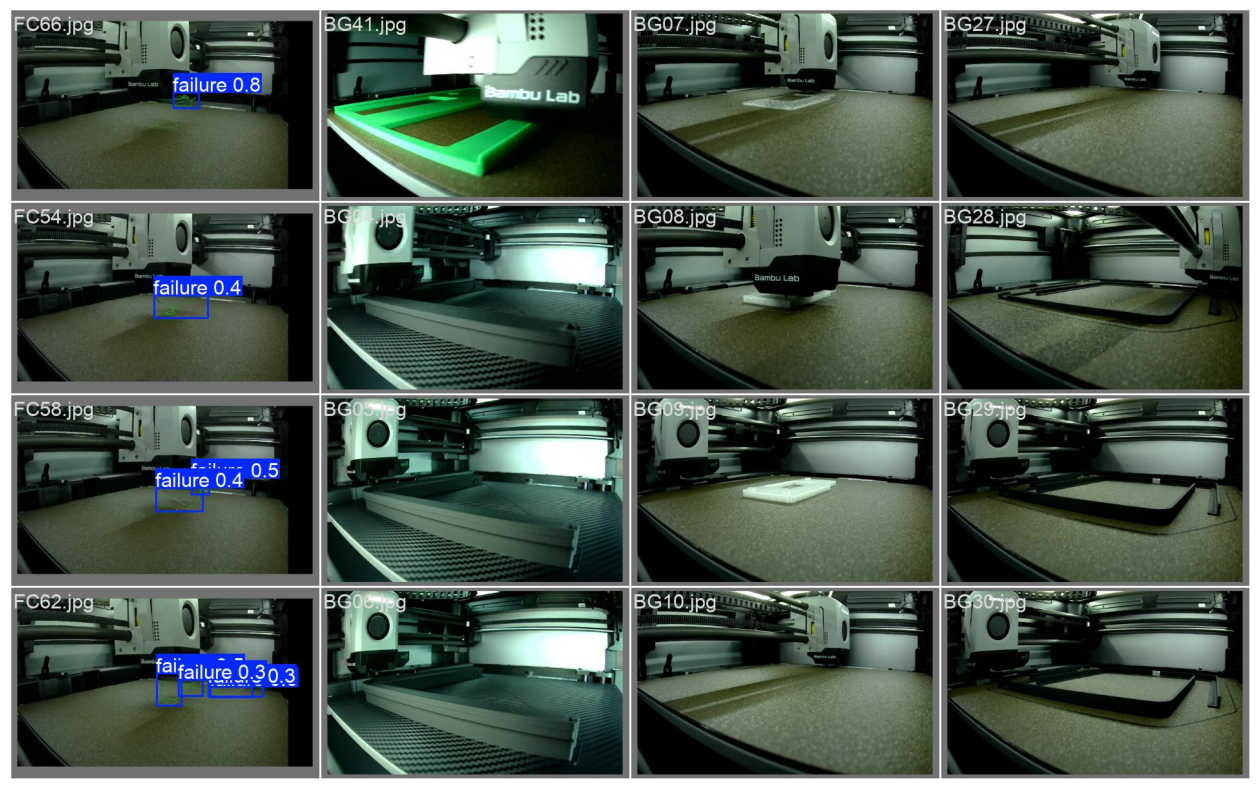

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
count = 1
for path in [image1, image2, image3, image4]:

    if ((count % 2) == 0):
        print(f"------------------ [LABEL] {path} ------------------")
    else:
        print(f"------------------ [PREDICTION] {path} ------------------")
    count += 1;

    img = mpimg.imread(path)
    plt.figure(figsize=(16, 16))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    
    print("\n")

# Evaluation

#### *On initial dataset of 350 images!*

- Overall it performed unexpectedly well based on the generated images. Except for FC46.jpg where it was unable to detect the very small loose filament oozing from the nozzle.

- It was able to correctly identify at least one failure from each of the images with failures. 

- Crucially, none of the background images have any false positives. This is important, as it means it has a low false positive rate, or high precision. In most AI fault detection systems, a false positive will cause the print to stop until a human gives it the clearance to proceed if it was a false positive, wasting time.**